In [1]:
import os, re, pdb
import pandas as pd
import matplotlib.pyplot as plt
from natsort import natsorted 
import numpy as np

import time
import sys
sys.path.append('../')
sys.path.append('../cobs')

from model import Model

# Baseline Blind and Daylighting Strategies

In [216]:
def load_baseline(s, b, d, stpt, customOcc=False):
    if customOcc:
        fname = f'../baselines/SAT_SP_customOcc_{s}_blinds{b}_setpoint{stpt}_daylighting{d}.csv'
    else:
        fname = f'../baselines/SAT_SP_{s}_blinds{b}_setpoint{stpt}_daylighting{d}.csv'
        
#     print(fname)
    df = pd.read_csv(fname, index_col='time')
    df.index = pd.to_datetime(df.index)
    if s == 'heating':
        df = df['1991-01-01 00:15:00':'1991-02-02 00:00:00']
    else:
        df = df['1991-07-01 00:15:00':'1991-08-02 00:00:00']
        
    df['Lights'] = (df['Lights Zone 1'] + df['Lights Zone 2'] +  df['Lights Zone 3'] +  df['Lights Zone 4']) / 4
    df['PMV'] = (df['PMV Zone 1'] + df['PMV Zone 2'] + df['PMV Zone 3'] + df['PMV Zone 4'] + df['PMV Zone 5']) / 5
    df['Illum Zone 1'] = (df['Illum 1 Zone 1'] + df['Illum 2 Zone 1']) / 2
    df['Illum Zone 3'] = (df['Illum 1 Zone 3'] + df['Illum 2 Zone 3']) / 2
    df['Illum'] = (df['Illum Zone 1'] + df['Illum Zone 3'] + df['Illum 1 Zone 2'] + df['Illum 1 Zone 4']) / 4
    
    comfort = df[df['Occupancy Flag'] == 1].copy()
    illum_viol = (len(comfort[(comfort['Illum'] > 750) | (comfort['Illum'] < 300)]) / len(comfort)) * 100
    pmv_viol = (len(comfort[abs(comfort["PMV"]) > 0.7]) / len(comfort)) * 100
    
    print(df['HVAC Power'].sum(), df['Lights'].sum(), df['Illum'].max())
    return df['HVAC Power'].sum() / 1000, illum_viol, pmv_viol, df['Lights'].sum() / 1000, df

In [217]:
# def load_baseline_customOcc(s, b, d, stpt):
#     fname = f'../baselines/SAT_SP_customOcc_{s}_blinds{b}_setpoint{stpt}_daylighting{d}.csv'
#     df1 = pd.read_csv(fname, index_col='time')
#     df1.index = pd.to_datetime(df1.index)
#     if s == 'heating':
#         df1 = df1['1991-01-01 00:15:00':'1991-02-02 00:00:00']
#     else:
#         df1 = df1['1991-07-01 00:15:00':'1991-08-02 00:00:00']
        
#     df = df1.copy()
        
#     occ_zone_1 = df['SPACE1-1 Occupied']
#     occ_zone_2 = df['SPACE2-1 Occupied']
#     occ_zone_3 = df['SPACE3-1 Occupied']
#     occ_zone_4 = df['SPACE4-1 Occupied']
#     occ_zone_5 = df['SPACE5-1 Occupied']
        
#     df['Lights'] = (df['Lights Zone 1'] + df['Lights Zone 2'] +  df['Lights Zone 3'] +  df['Lights Zone 4'] +  df['Lights Zone 5']) / 5
# #     df['PMV'] = (df['PMV Zone 1'] * occ_zone_1 + df['PMV Zone 2'] * occ_zone_2 + df['PMV Zone 3'] * occ_zone_3 + df['PMV Zone 4'] * occ_zone_4 + df['PMV Zone 5'] * occ_zone_5) / 5
    
#     df['Illum 1 Zone 1'] = (df['Illum 1 Zone 1'] + df['Illum 2 Zone 1']) / 2
#     df['Illum 1 Zone 3'] = (df['Illum 1 Zone 3'] + df['Illum 2 Zone 3']) / 2
    
#     illum_violations = {}
#     pmv_violations = {}
#     for i in range(1,5):
#         illum_col = f'Illum 1 Zone {i}'
#         pmv_col = f'PMV Zone {i}'
#         occ_col = f'SPACE{i}-1 Occupied'
#         df.loc[df[occ_col] > 0, occ_col] = 1
#         df.loc[(df[illum_col] > 750) | (df[illum_col] < 300), illum_col] = 1
#         df.loc[(df[illum_col] <= 750) & (df[illum_col] >= 300), illum_col] = 0
#         df.loc[abs(df[pmv_col]) > 0.7, pmv_col] = 1
#         df.loc[abs(df[pmv_col]) <= 0.7, pmv_col] = 0
#         df[illum_col] = df[illum_col] * df[occ_col]
#         df[pmv_col] = df[pmv_col] * df[occ_col]
# #         pdb.set_trace()
#         illum_violations[f'Zone {i}'] = (df[illum_col].sum() / df[occ_col].sum()) * 100
#         pmv_violations[f'Zone {i}'] = (df[pmv_col].sum() / df[occ_col].sum()) * 100

#     print(df['HVAC Power'].sum(), df['Lights'].sum())
#     return df['HVAC Power'].sum() / 1000, illum_violations, pmv_violations, df['Lights'].sum() / 1000, df1

In [218]:
def plot_strategies(customOcc):
    for s in ['heating', 'cooling']:
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        for b in ['None', 'SouthOnly', 'All', 'AllAlwaysOn']:
            for d in [True, False]:
                hvacs = []
                iviols = []
                pviols = []
                lights = []
                if s == 'cooling':
                    stpts = [0, 100, 200, 300, 400, 500]
                else:
                    stpts = [-10, -5, 0, 5, 10]
                for stpt in stpts:
                    try:
                        if customOcc:
                            hvac, iviol, pviol, light, _ = load_baseline_customOcc(s, b, d, stpt, customOcc)
                        else:
                            hvac, iviol, pviol, light, _ = load_baseline(s, b, d, stpt, customOcc)
                        hvacs.append(hvac)
                        iviols.append(iviol)
                        pviols.append(pviol)
                        lights.append(light)
                    except FileNotFoundError as e:
                        print(e)
                if len(hvacs) == len(stpts):
                    axes[0].plot(stpts, hvacs, label=f"Blinds: {b}, Daylighting: {d}")
                    axes[0].set_title('HVAC Power (kW)', fontsize=15)
                    axes[1].plot(stpts, iviols, label=f"Blinds: {b}, Daylighting: {d}")
                    axes[1].set_title('Illumination Violation (%)', fontsize=15)
                    axes[2].plot(stpts, pviols, label=f"Blinds: {b}, Daylighting: {d}")
                    axes[2].set_title('PMV Violation (%)', fontsize=15)
                    axes[3].plot(stpts, lights, label=f"Blinds: {b}, Daylighting: {d}")
                    axes[3].set_title('Lights Power (kW)', fontsize=15)
        plt.legend(loc='upper center',bbox_to_anchor=(-1.2, -0.05), fontsize=15, ncol=4)
        plt.show()

24883070.637639537 802777.854725911 8503.346500378066
24883070.637639537 802777.854725911 8503.346500378066
24883070.637639537 802777.854725911 8503.346500378066
24883070.637639537 802777.854725911 8503.346500378066
24883070.637639537 802777.854725911 8503.346500378066
22918924.819263674 1553126.4 8503.346500378066
22918924.819263674 1553126.4 8503.346500378066
22918924.819263674 1553126.4 8503.346500378066
22918924.819263674 1553126.4 8503.346500378066
22918924.819263674 1553126.4 8503.346500378066
24828619.498222195 802777.854725911 8503.346500378066
24738270.56450727 802777.854725911 8503.346500378066
24650541.828342464 802777.854725911 8503.346500378066
24629075.971139155 802777.854725911 8503.346500378066
24626133.73169285 802777.854725911 8503.346500378066
22863603.914684087 1553126.4 8503.346500378066
22768726.427156538 1553126.4 8503.346500378066
22680973.108308673 1553126.4 8503.346500378066
22660752.510910027 1553126.4 8503.346500378066
22656504.05173237 1553126.4 8503.346500

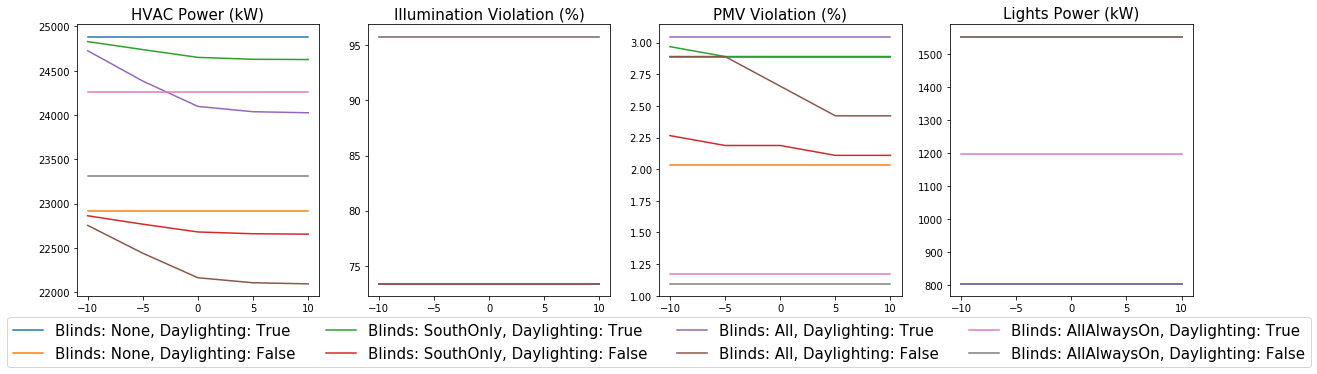

8065302.9409121275 529089.8941508506 7165.606896835905
8065302.9409121275 529089.8941508506 7165.606896835905
8065302.9409121275 529089.8941508506 7165.606896835905
8065302.9409121275 529089.8941508506 7165.606896835905
8065302.9409121275 529089.8941508506 7165.606896835905
8065302.9409121275 529089.8941508506 7165.606896835905
10014969.622985791 1553126.4 7165.606896835905
10014969.622985791 1553126.4 7165.606896835905
10014969.622985791 1553126.4 7165.606896835905
10014969.622985791 1553126.4 7165.606896835905
10014969.622985791 1553126.4 7165.606896835905
10014969.622985791 1553126.4 7165.606896835905
7719840.751993615 655972.018065204 7113.574227087023
7977743.083348275 576259.5009673666 7165.606896835905
8065302.9409121275 529089.8941508506 7165.606896835905
8065302.9409121275 529089.8941508506 7165.606896835905
8065302.9409121275 529089.8941508506 7165.606896835905
8065302.9409121275 529089.8941508506 7165.606896835905
9518257.7038033 1553126.4 7113.574227087023
9405115.200072935

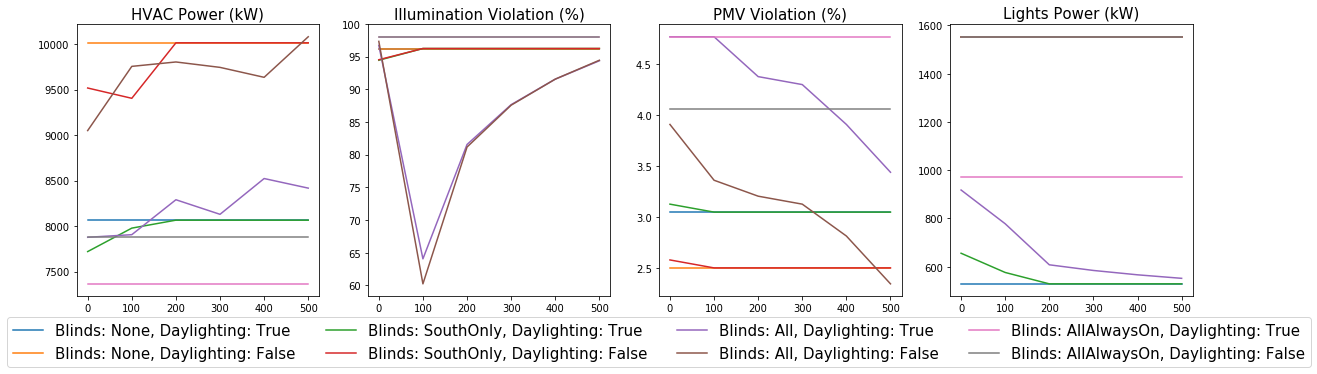

In [219]:
plot_strategies(False)

In [130]:
# plot_strategies(True)

In [133]:
hvac, iviol, pviol, light, df = load_baseline_customOcc('cooling', 'All', 'True', 100)

In [134]:
iviol

{'Zone 1': 38.48039215686275,
 'Zone 2': 94.21296296296296,
 'Zone 3': 35.32608695652174,
 'Zone 4': 96.37096774193549}

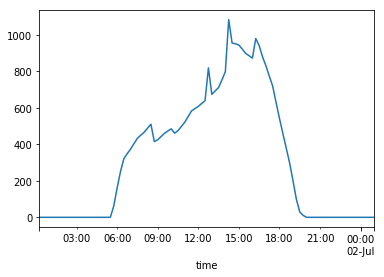

In [138]:
df[:100]['Illum 1 Zone 1'].plot()

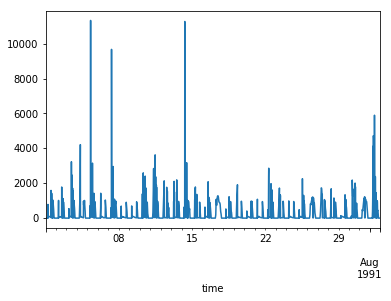

In [141]:
df['Illum 1 Zone 2'].plot()

# Policies

In [65]:
blinds = ['Blind Angle Zone 1', 'Blind Angle Zone 2', 'Blind Angle Zone 3', 'Blind Angle Zone 4']
temps = ['Temp Zone 1', 'Temp Zone 2', 'Temp Zone 3', 'Temp Zone 4', 'Temp Zone 5']
pmvs = ['PMV Zone 1', 'PMV Zone 2', 'PMV Zone 3', 'PMV Zone 4', 'PMV Zone 5']
lights = ['Lights Zone 1', 'Lights Zone 2', 'Lights Zone 3', 'Lights Zone 4']
innode_temp = ['In Node Temp Zone 1', 'In Node Temp Zone 2', 'In Node Temp Zone 3', 'In Node Temp Zone 4', 'In Node Temp Zone 5']
innode_flow = ['In Node Flow Zone 1', 'In Node Flow Zone 2', 'In Node Flow Zone 3', 'In Node Flow Zone 4', 'In Node Flow Zone 5']
illums = ['Illum 1 Zone 1', 'Illum 1 Zone 2', 'Illum 1 Zone 3', 'Illum 1 Zone 4']

def plot_vars_separate(period, s, b, d):
    if s == 'cooling': 
        stpt = 100
    if s == 'heating':
        stpt = 15
    fname = f'../baselines/SAT_SP_{s}_blinds{b}_setpoint{stpt}_daylighting{d}.csv'
    df = pd.read_csv(fname)
#     pdb.set_trace()
    fig, axes = plt.subplots(7, figsize=(15,15), sharex=True)
    plt.suptitle(f"{s}, Blinds: {b}, Daylighting: {d}", fontsize=20)
    if period == 'month':
        idx = len(df)
    if period == 'day':
        idx = 24 * 4
    if period == 'week':
        idx = 24 * 7 * 4
    df[blinds][0:idx].plot(ax=axes[0], title='Blind Angle')
    df[temps][0:idx].plot(ax=axes[1], title='Indoor Air Temperature')
    df['Outdoor Temp.'][0:idx].plot(ax=axes[1], color='Black')
    df[pmvs][0:idx].plot(ax=axes[2], title='PMV')
    df[lights][0:idx].plot(ax=axes[3], title='Lighting Power')
    df[innode_temp][0:idx].plot(ax=axes[4], title='Air Distribution Unit Outlet Node Temperature')
    df[innode_flow][0:idx].plot(ax=axes[5], title='Air Distribution Unit Outlet Node Mass Flow Rate')
    df[illums][0:idx].plot(ax=axes[6], title='Illumination')
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    axes[2].get_legend().remove()
    axes[3].get_legend().remove()
    axes[4].get_legend().remove()
    axes[5].get_legend().remove()
    axes[6].get_legend().remove()
    plt.show()

==== heating None True


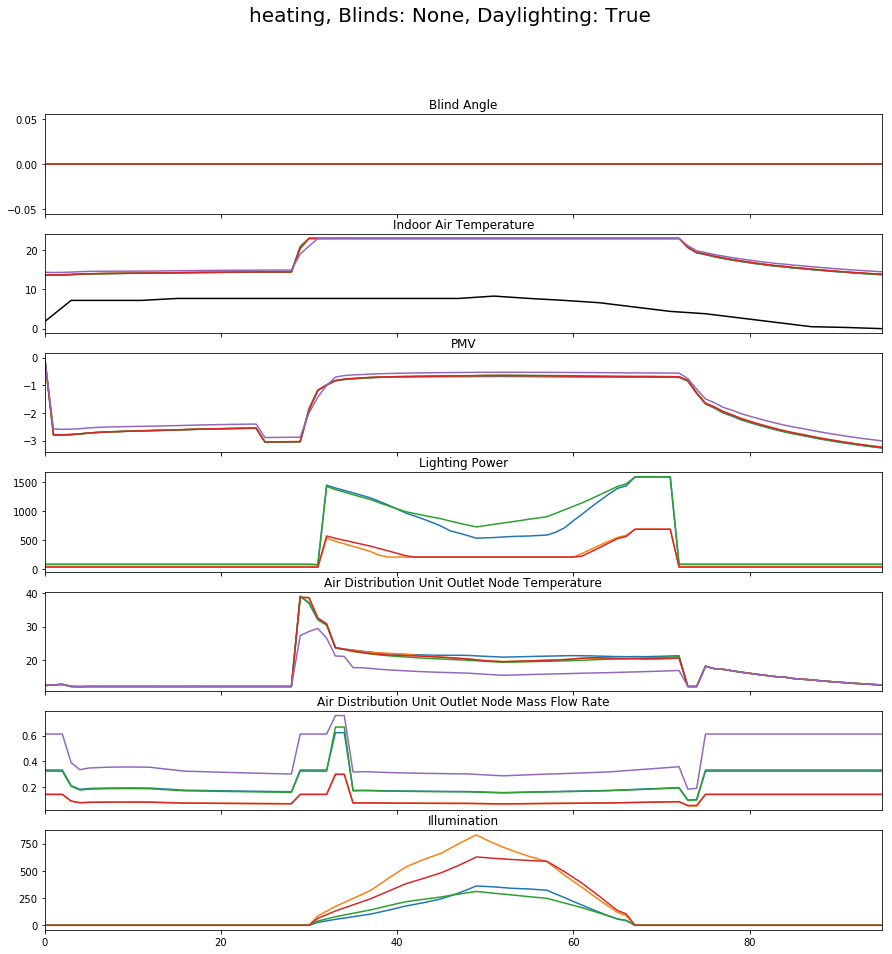

==== heating None False


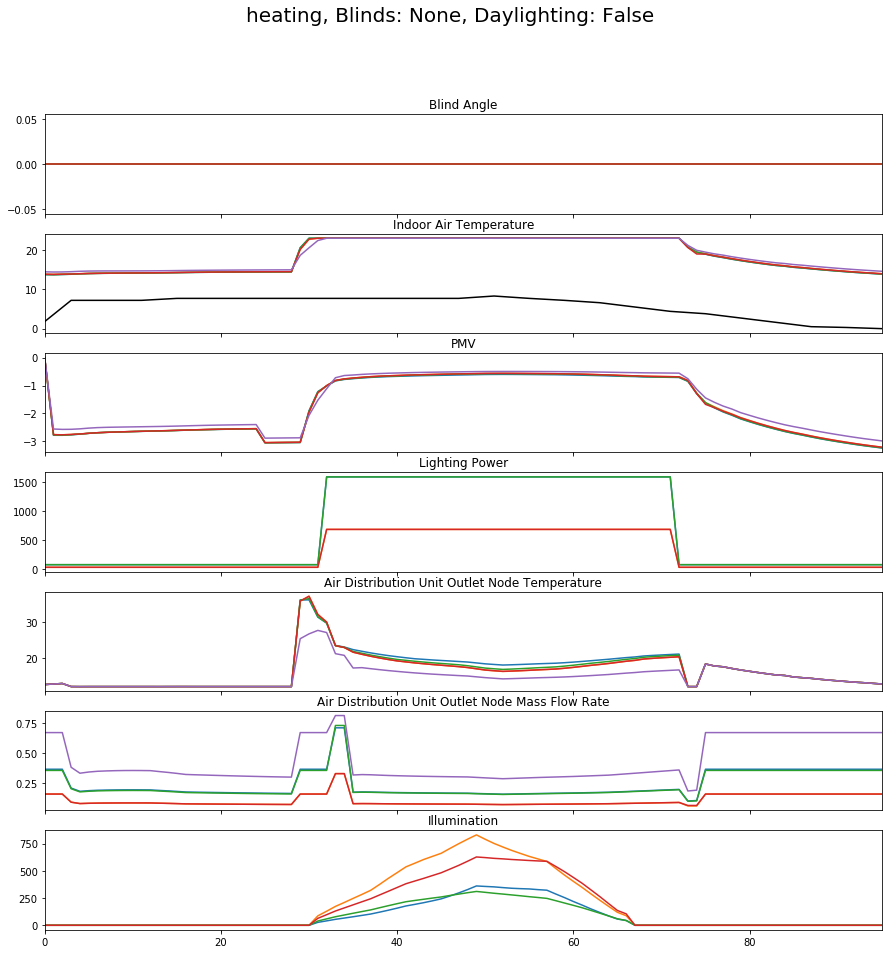

==== heating SouthOnly True


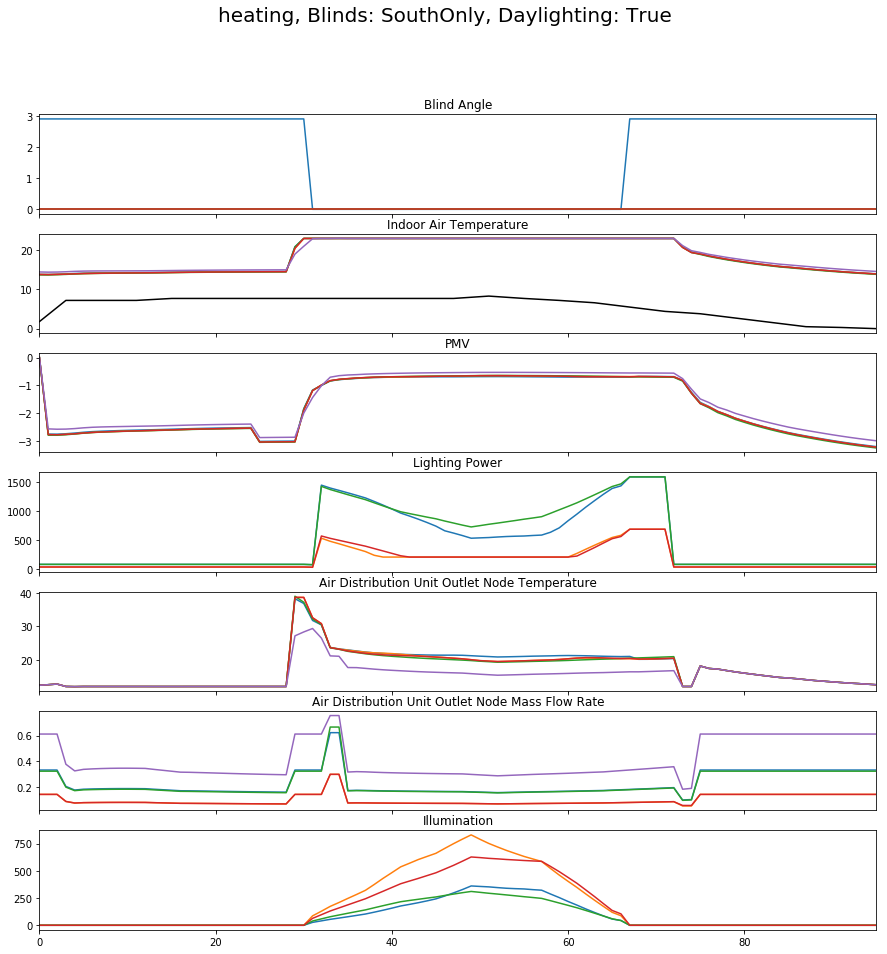

==== heating SouthOnly False


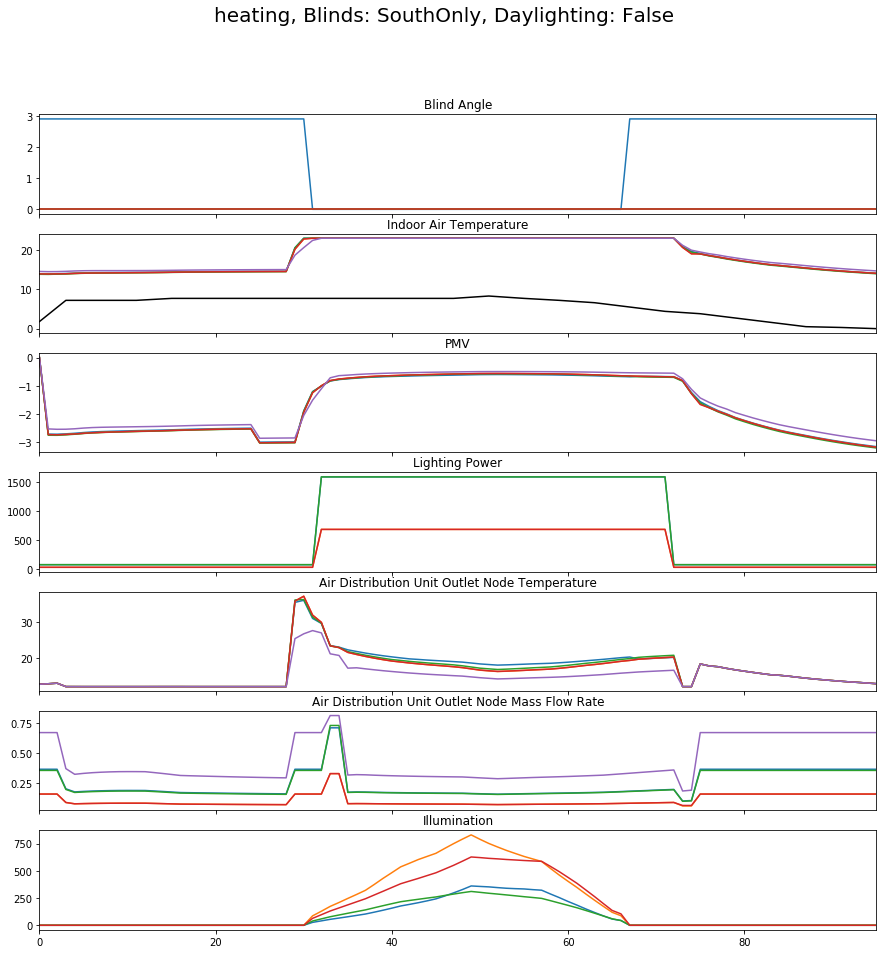

==== heating All True


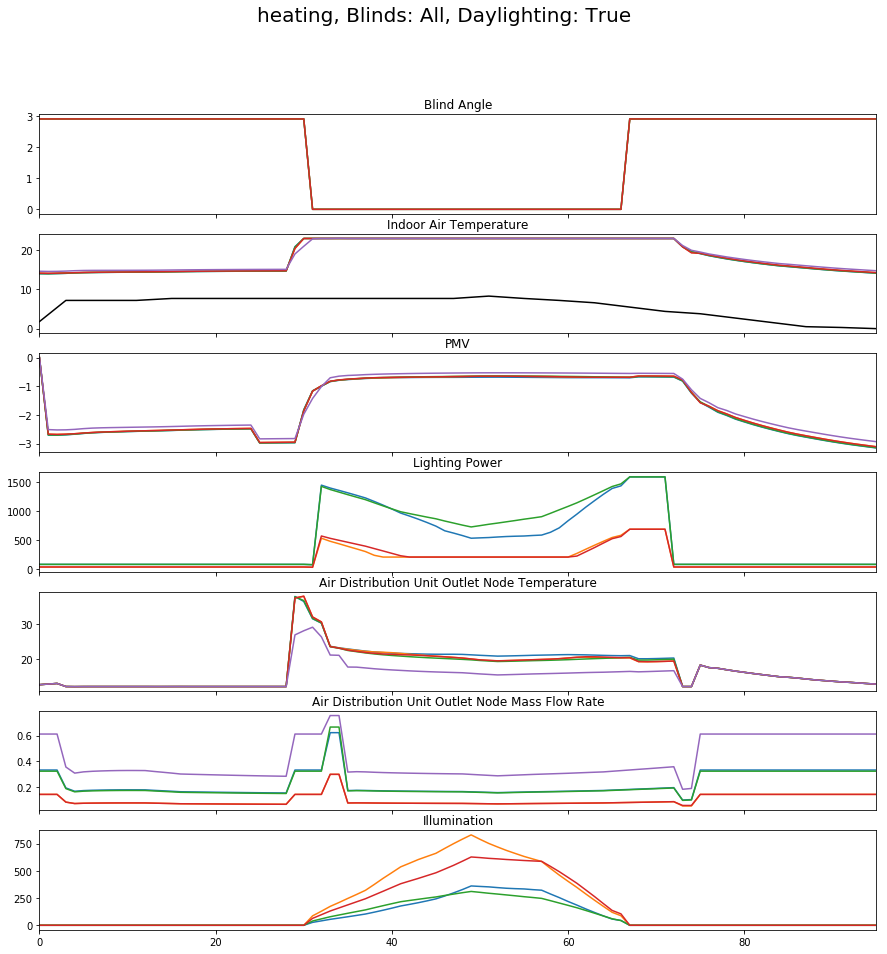

==== heating All False


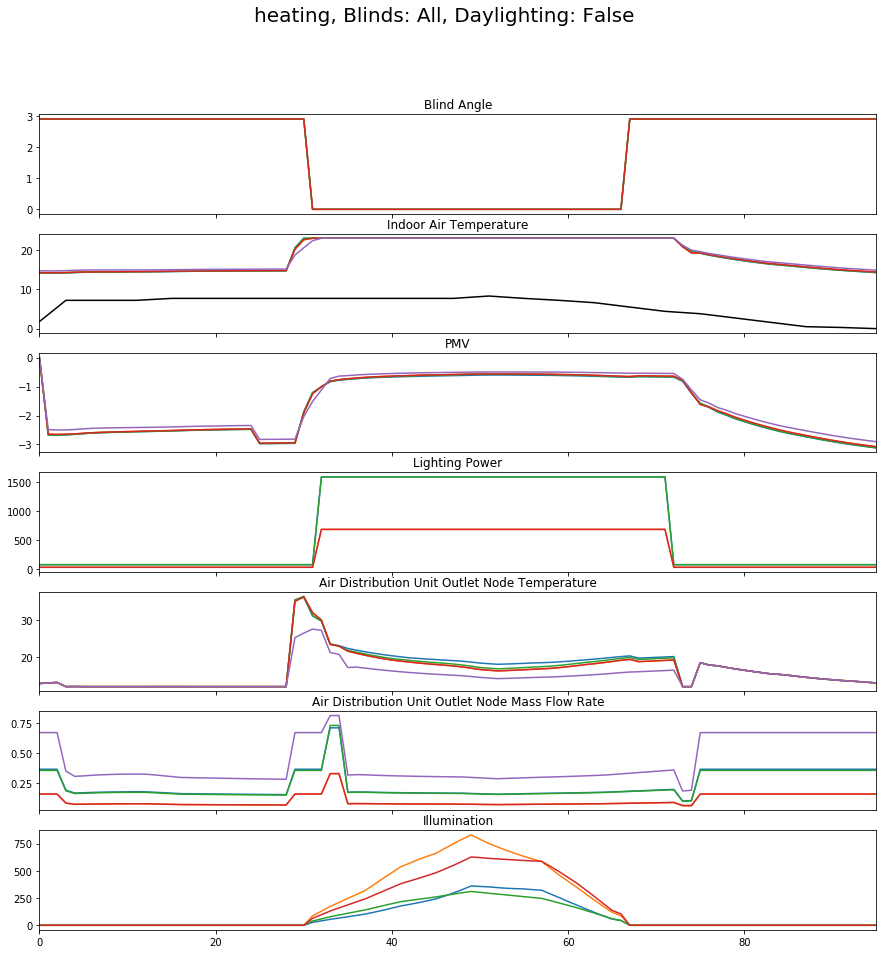

==== heating AllAlwaysOn True


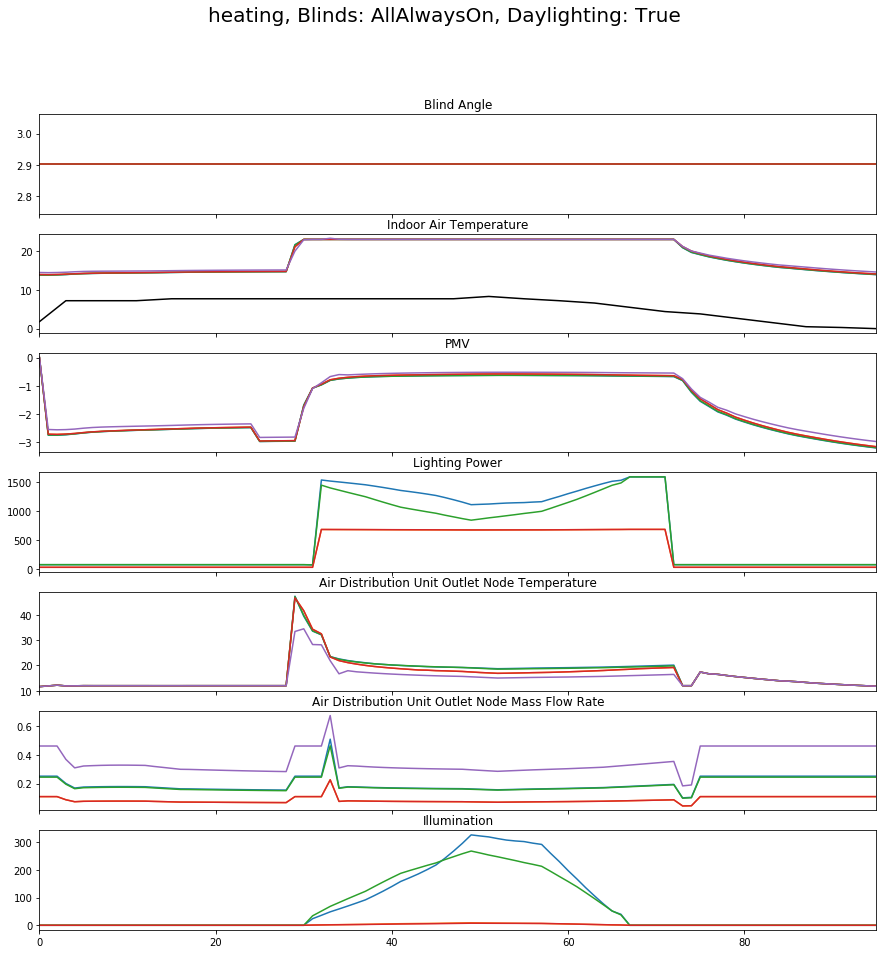

==== heating AllAlwaysOn False


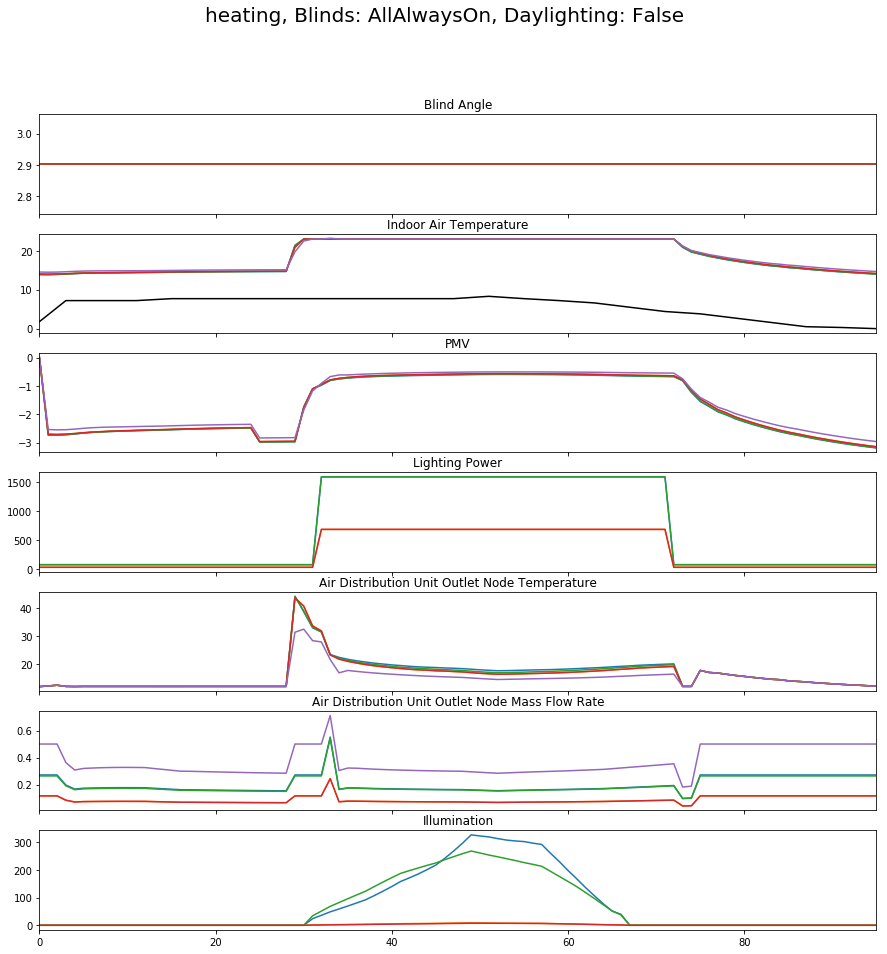

==== cooling None True


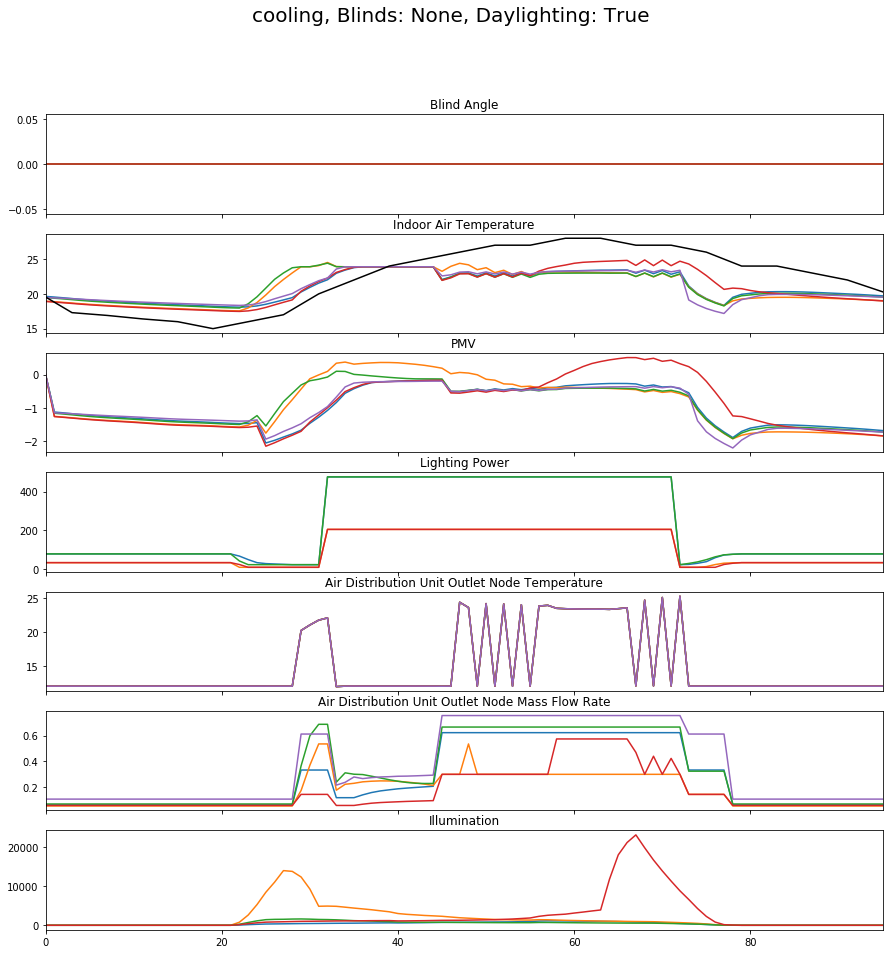

==== cooling None False


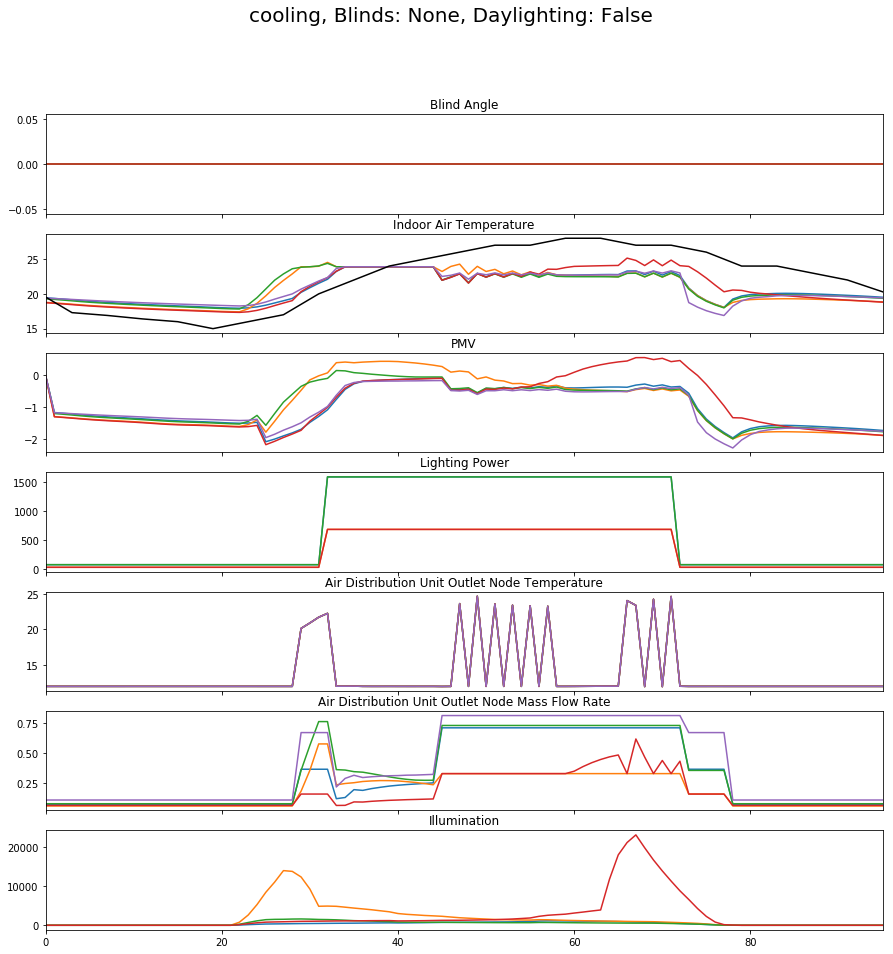

==== cooling SouthOnly True


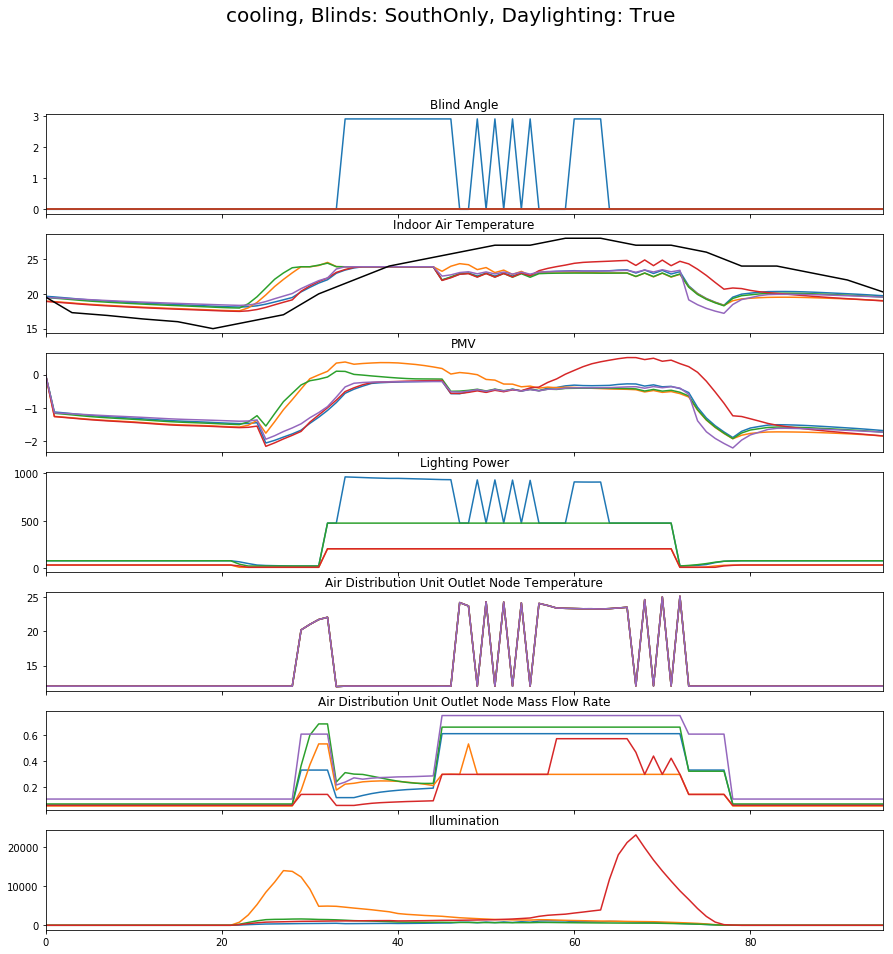

==== cooling SouthOnly False


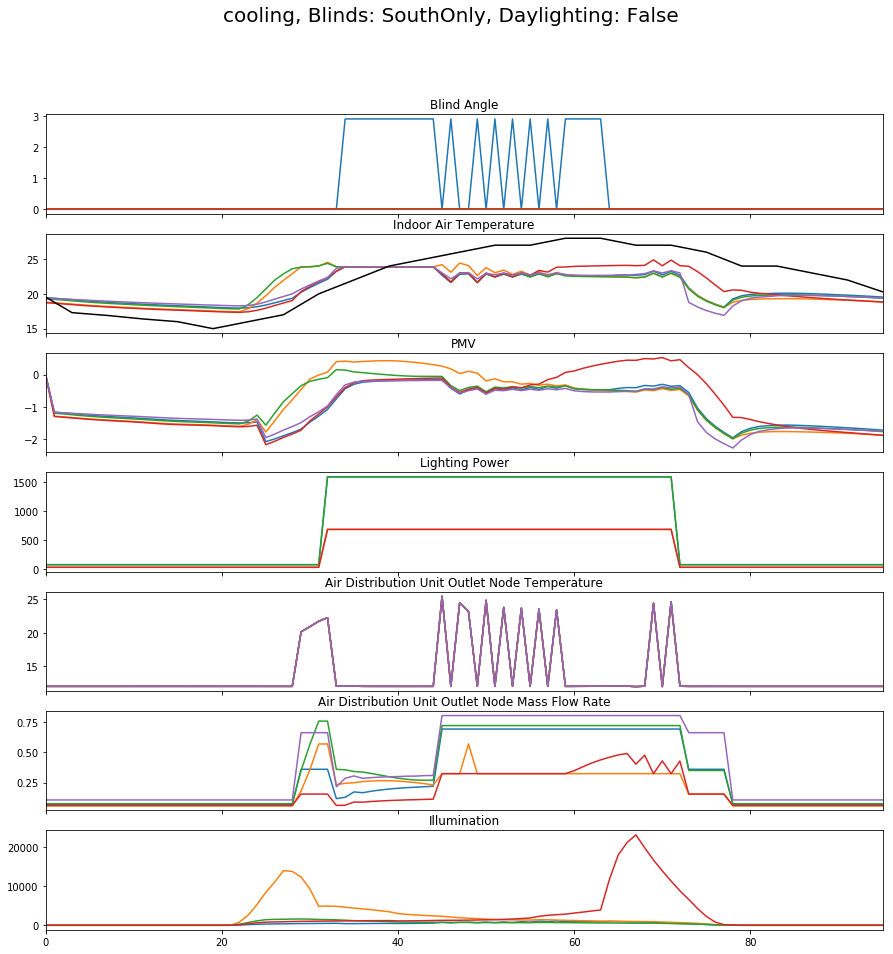

==== cooling All True


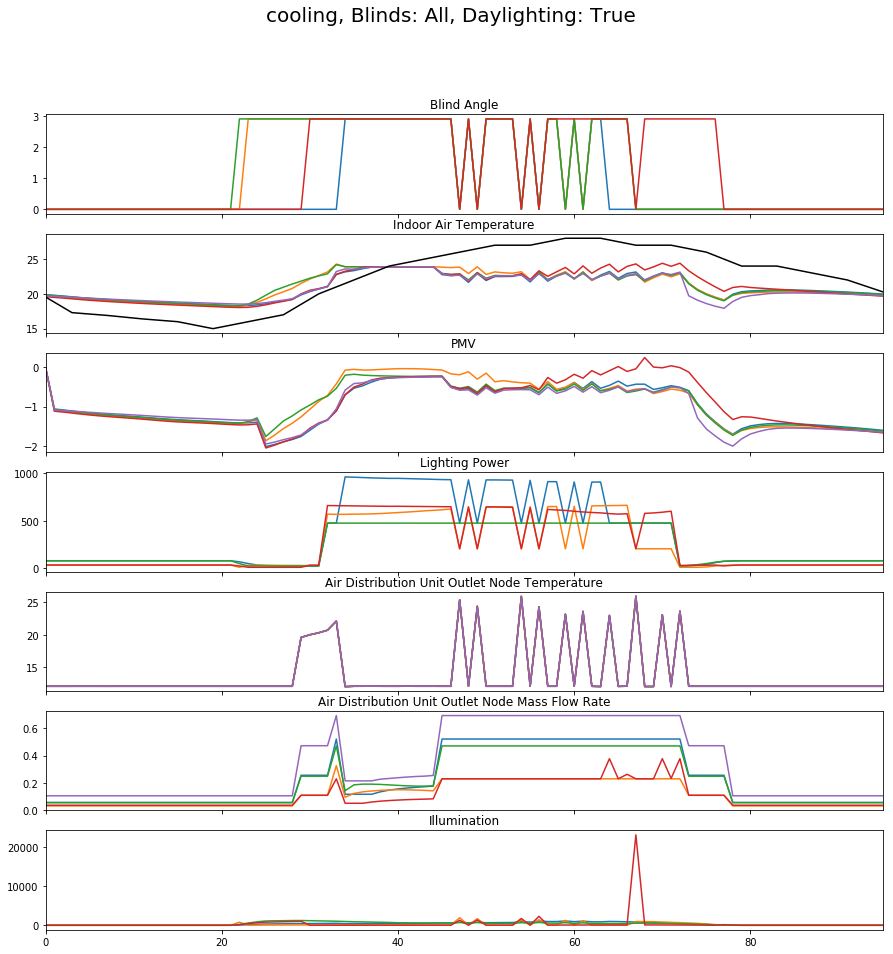

==== cooling All False


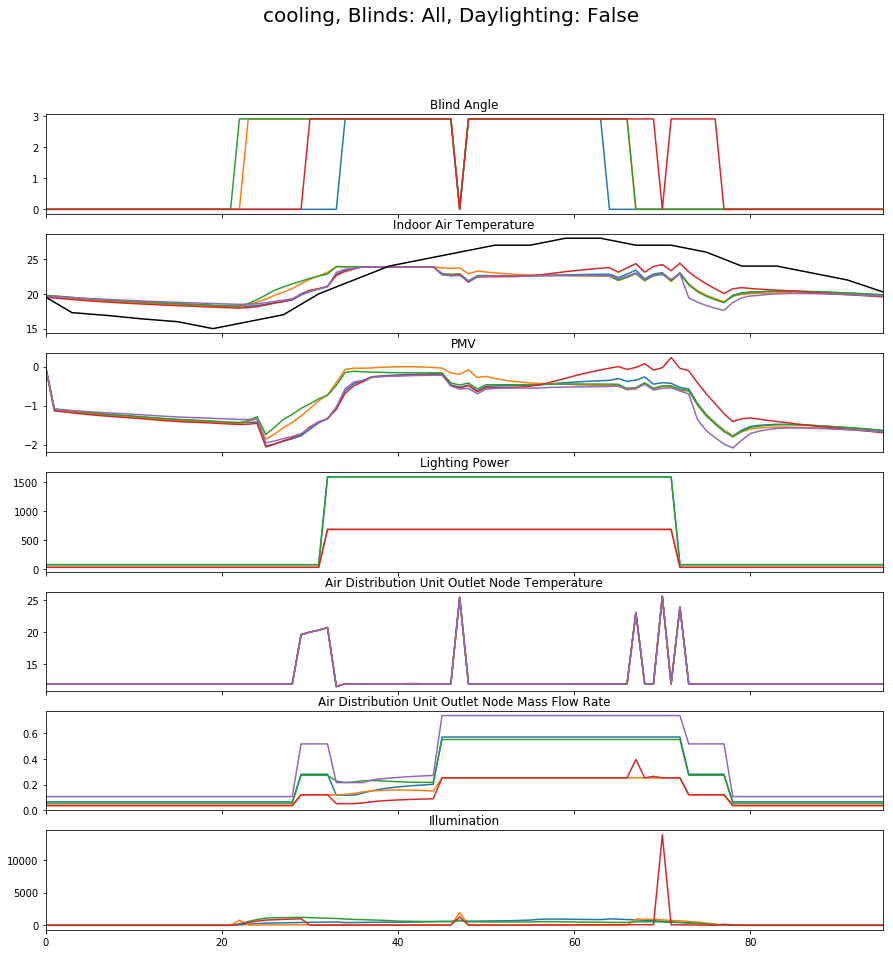

==== cooling AllAlwaysOn True


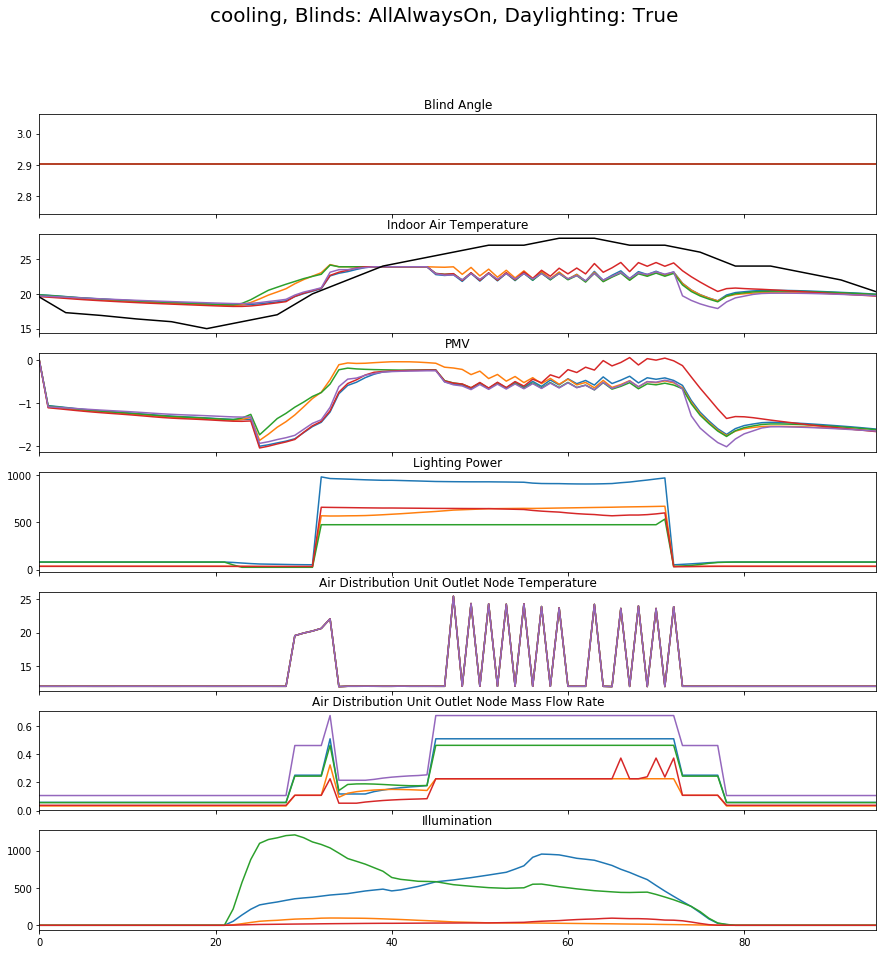

==== cooling AllAlwaysOn False


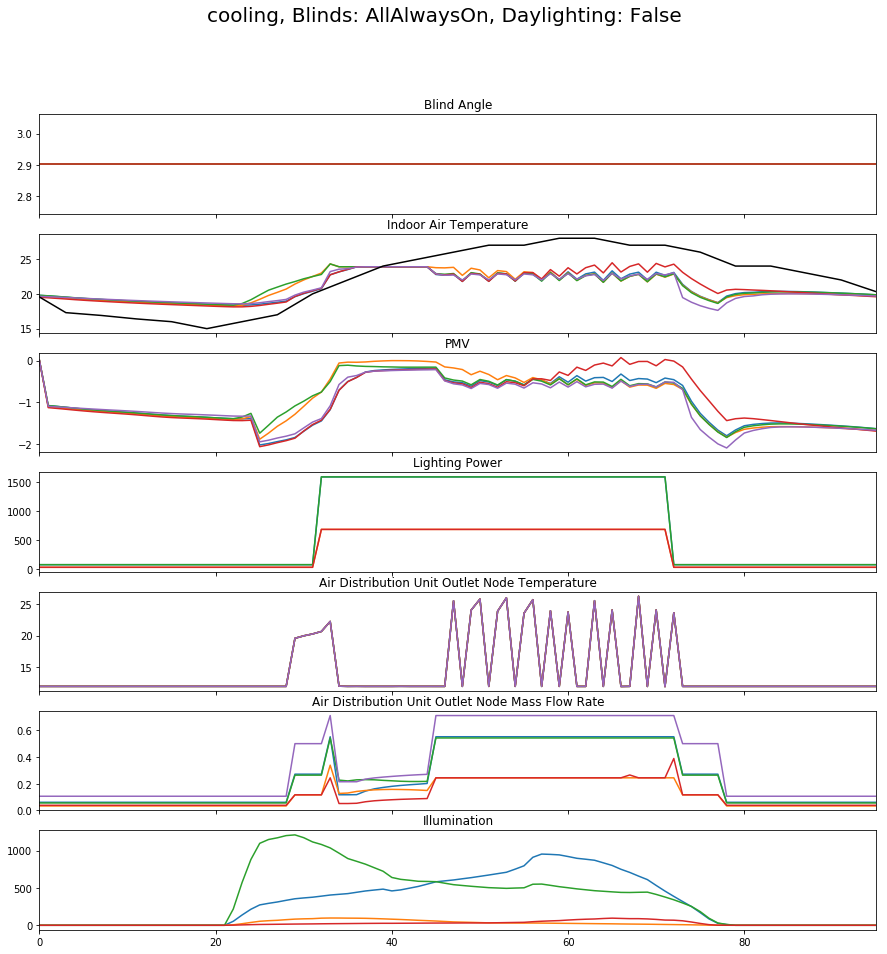

In [167]:
for s in ['heating', 'cooling']:
    for b in ['None', 'SouthOnly', 'All', 'AllAlwaysOn']:
        for d in [True, False]:
            print('====',s,b,d)
            plot_vars_separate('day',s,b,d)